## Get distances from co-occurance, using PV data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
from matplotlib.colors import LogNorm

import seaborn as sns

%matplotlib inline
%reload_ext line_profiler

In [5]:
file_to_load = '/Users/ahuxor/MSc/Thesis_Project/Data/patentsView/cpc_current.tsv'

# read in CPC data, but only for columns with patent number, section, CPC3 and CPC4
# takes 30secs
pv_cpc_df = pd.read_csv(file_to_load,sep='\t',usecols=[1,2,3,4])

In [6]:
# a sanity check on the CPC sections indicates that the CPC codes have all been cleaned
unique_cpc_section_list = pv_cpc_df.section_id.unique().tolist()
print(unique_cpc_section_list)

['H', 'G', 'A', 'Y', 'B', 'F', 'E', 'D', 'C']


In [9]:
!pwd

/Users/ahuxor/MSc/Thesis_Project/Data/nber_dataset/for_safe


In [10]:
# load in data used for Yan sample, just to get patent numbers for 1997-1990
ipc3_1976_1990_df = pd.read_csv('../ipc3_1976_1990_df.csv',usecols=[0,1])

In [11]:
#rename column for PID to patent_id
ipc3_1976_1990_df.rename(columns={'PID':'patent_id'}, inplace=True)

In [12]:
# now join this IPC3 file with the PV file to get the CPC codes for these patent numbers
pv_76_90_df = pd.merge(ipc3_1976_1990_df, pv_cpc_df, how='left', on= 'patent_id')
print('length of pv_76_90_df = ',len(pv_76_90_df))

length of pv_76_90_df =  4721490


In [13]:
# create list for unique_icl_section. Should just be the A to H sections
unique_cpc_section_list = ['A','B','C','D','E','F','G','H','Y']

In [14]:
# create list of unique assignee numbers
unique_patents = pv_76_90_df.patent_id.unique()

In [15]:
# create starter df for feature vectors based on section
feature_vectors_df = pd.DataFrame({'cpc_section' : ['A','B','C','D','E','F','G','H','Y']})

In [16]:
len(unique_patents)

1047550

In [17]:

# num = number of patents to look at (to test code with small samples first)
def get_patent_PVsection_counts_for_patents(num):
    feature_vectors_list_of_lists =[]
    # first get list of (unique) assignees (try first five first to test code)
    range_of_patents = unique_patents[0:num]
    # then for each one of them, 
    for a_patent in range_of_patents:
        #print('patent number = ',a_patent)
        # look at all the patent sections each patent has #
        temp = pv_76_90_df[pv_76_90_df.patent_id==a_patent].section_id
        section_codes_in_current_list = list(temp.values)
        #print(section_codes_in_current_list)
        #  and count instances of these if multiple instances of any 
        n = len(unique_cpc_section_list)
        cpc_codes_per_patent_list = []
        for m in range(0,n):
            current_cpc_section = unique_cpc_section_list[m]
            counted = section_codes_in_current_list.count(current_cpc_section)
            cpc_codes_per_patent_list.append(counted)
        feature_vectors_list_of_lists.append((cpc_codes_per_patent_list))
    return(feature_vectors_list_of_lists)

In [18]:

# 1047550 (full sample) takes 1h 33min
j=1047550
# %lprun -f get_patent_section_counts_for_patents feature_lists = get_patent_section_counts_for_patents(j)
PVsection_counts_per_patent = get_patent_PVsection_counts_for_patents(j)

In [19]:
PVsection_counts_per_patent_df = pd.DataFrame(PVsection_counts_per_patent)

In [20]:
# add column names to df from unique_cpc_section_list names
PVsection_counts_per_patent_df.columns = unique_cpc_section_list

In [21]:
# add patent numbers as index 
# first get required number (function of j, remember), then convert to integer
patents_for_index = unique_patents[:len(PVsection_counts_per_patent_df)]
patents_for_index
# then change index for df
indexed_PVsection_counts_per_patent_df = PVsection_counts_per_patent_df.set_index(patents_for_index)
indexed_PVsection_counts_per_patent_df.tail()

,A,B,C,D,E,F,G,H,Y
4258235,0,0,0,0,0,0,0,2,0
4660017,0,0,0,0,0,0,0,1,0
4734622,0,0,0,0,0,0,0,4,0
4600952,0,0,0,0,0,0,5,1,0
4959326,0,0,0,0,0,0,0,2,0


In [22]:
# create clipped version of df with value =1 for any value of 1 and above 
indexed_PVsection_counts_per_patent_df_clipped = indexed_PVsection_counts_per_patent_df.clip(0,1)
indexed_PVsection_counts_per_patent_df_clipped.tail()

,A,B,C,D,E,F,G,H,Y
4258235,0,0,0,0,0,0,0,1,0
4660017,0,0,0,0,0,0,0,1,0
4734622,0,0,0,0,0,0,0,1,0
4600952,0,0,0,0,0,0,1,1,0
4959326,0,0,0,0,0,0,0,1,0


In [24]:
# load data with forward citations
pat76_06_assg_df = pd.read_stata('../pat76_06_assg.dta')


In [25]:
len(indexed_PVsection_counts_per_patent_df_clipped)

1047550

In [26]:

# full sample takes 2hrs 23 min
list_of_sections = ['A','B','C','D','E','F','G','H','Y']
#create empty lists to hold values generated
firsts_list_PVsections = []
seconds_list_PVsections = []
ratio_list_PVsections = []
patent_counts_list_PVsections = []
# set threshold value for forward citations, to derive ratio of high to low forward citations
threshold = 20
# create short-name version of the long but descriptive df, for use in loop
short_name_df = indexed_PVsection_counts_per_patent_df_clipped
for y in range(0,9):
    first = list_of_sections[y]
    for z in range(0,9):
        second = list_of_sections[z]
        #print('dyad=',first,'/', second)
        #get patents which have both of these sections
        matches_dyad = short_name_df[(short_name_df[first]==1) & (short_name_df[second]==1)]
        # throw out those that also have other sections (for clean sampling)
        matches_dyad_no_others = matches_dyad[matches_dyad.sum(axis=1)<3]
        #get actual patent numbers (used as index for thes dfs)
        patents = matches_dyad_no_others.index.values
        #print(patents)
        count_patents = len(patents)
        # obtain the number of forward citations
        forward_cites_list = []
        for a_patent in patents:
            # get record for this patent from 76-06-assg
            record = pat76_06_assg_df[pat76_06_assg_df.patent==a_patent]
            # have a case where the patent number has no record in pat76_06_assg_df, so exclude such cases
            if not record.empty:
                forward_cites = record.allcites.values[0] # get number of forward cites for each patent
                #print(forward_cites)
                forward_cites_list.append(forward_cites)
        # derive ratio citations above/below threshold
        num_above_threshold = len([i for i in forward_cites_list if i >= threshold])
        num_below_threshold = len([i for i in forward_cites_list if i < threshold])
        # need to handle num_below_threshold =0, as get divide by zero error in some cases
        if (num_below_threshold == 0):
            num_below_threshold = 1.0
        citations_ratio = num_above_threshold/num_below_threshold
        #print('ratio = ', citations_ratio)
        firsts_list_PVsections.append(first)
        seconds_list_PVsections.append(second)
        ratio_list_PVsections.append(citations_ratio)
        patent_counts_list_PVsections.append(count_patents)
print('DONE')       

DONE


In [27]:
# create dataframe from these lists for the forward citations
forw_cite_ratio_df_PVsections = pd.DataFrame(
    {'first_section': firsts_list_PVsections,
     'second_section': seconds_list_PVsections,
     'forw_cite_ratio': ratio_list_PVsections
    })

# create dataframe from these lists for patent counts
patent_counts_df_PVsections = pd.DataFrame(
    {'first_section': firsts_list_PVsections,
     'second_section': seconds_list_PVsections,
     'patent_counts': patent_counts_list_PVsections
    })

In [28]:
# convert the forward citation dataframe into another representing the matrix
PVsection_forw_cite_ratios = forw_cite_ratio_df_PVsections.pivot(index='first_section',columns='second_section',values='forw_cite_ratio')

In [29]:
# normalize the counts to account for different patent proposensity
normalized_counts_list_PVsections = []
for n in range(0,len(patent_counts_df_PVsections)):
    record = patent_counts_df_PVsections[n:n+1]
    first = record.first_section.values[0]
    first_lone = patent_counts_df_PVsections[(patent_counts_df_PVsections.first_section==first) & (patent_counts_df_PVsections.second_section==first) ]
    first_lone_counts = first_lone.patent_counts.values[0]
    first_lone_counts

    second = record.second_section.values[0]
    second_lone = patent_counts_df_PVsections[(patent_counts_df_PVsections.first_section==second) & (patent_counts_df_PVsections.second_section==second) ]
    second_lone_counts = second_lone.patent_counts.values[0]
    second_lone_counts
    if first==second:
        sum_lone_values = first_lone_counts
    else:
        sum_lone_values = first_lone_counts+second_lone_counts
    normalized_counts = record.patent_counts.values[0]/sum_lone_values
    normalized_counts_list_PVsections.append(normalized_counts)




In [30]:
# add the normalised counts to the df
patent_counts_df_PVsections['normalized_counts'] = normalized_counts_list_PVsections
patent_counts_df_PVsections.head()

,first_section,patent_counts,second_section,normalized_counts
0,A,144913,A,1.000000
1,A,8401,B,0.022608
2,A,14766,C,0.043848
3,A,576,D,0.003404
4,A,1114,E,0.005827


In [31]:
# convert the forward citation dataframe into another representing the matrix
PVsection_patent_counts = patent_counts_df_PVsections.pivot(index='first_section',columns='second_section',values='patent_counts')
# as above for for normalized counts
PVsection_patent_counts_norm = patent_counts_df_PVsections.pivot(index='first_section',columns='second_section',values='normalized_counts')

/Users/ahuxor/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


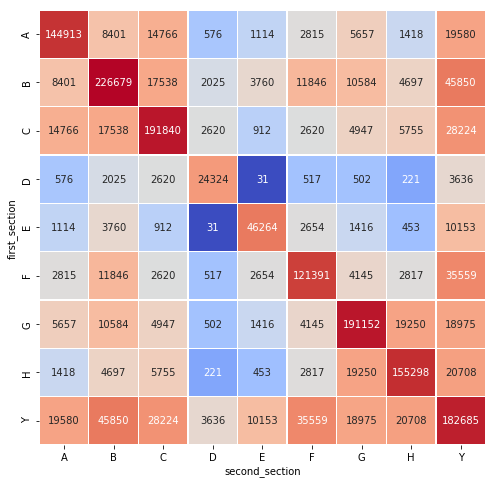

In [32]:
# plot raw counts
fig = plt.figure(figsize=(8,8))
sns.heatmap(PVsection_patent_counts, cmap='coolwarm', linewidths=0.5, annot=True, fmt="d", cbar=False, norm=LogNorm(vmin=PVsection_patent_counts.min(), vmax=PVsection_patent_counts.max()))
plt.savefig("/Users/ahuxor/MSc/Thesis_Project/msc_thesis/Figs/PVsection_patent_counts_heatmap.pdf", bbox_inches = 'tight')
fig.show()

/Users/ahuxor/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


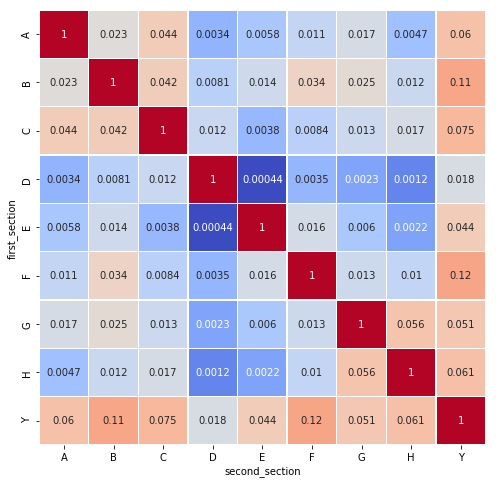

In [33]:
# plot normalised counts
fig = plt.figure(figsize=(8,8))
sns.heatmap(PVsection_patent_counts_norm, cmap='coolwarm', linewidths=0.5, cbar=False,annot=True,norm=LogNorm(vmin=PVsection_patent_counts.min(), vmax=PVsection_patent_counts.max()))
plt.savefig("/Users/ahuxor/MSc/Thesis_Project/msc_thesis/Figs/PVsection_patent_counts_norm_heatmap.pdf", bbox_inches = 'tight')
fig.show()

/Users/ahuxor/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


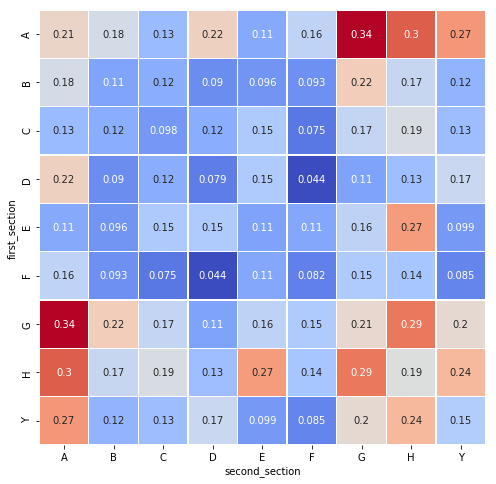

In [34]:
# plot forward citation ratios above/below threshold of 20
fig = plt.figure(figsize=(8,8))
sns.heatmap(PVsection_forw_cite_ratios, cmap='coolwarm', linewidths=0.5, annot=True, cbar=False)
plt.savefig("/Users/ahuxor/MSc/Thesis_Project/msc_thesis/Figs/PVsection_cite_ratios_heatmap.pdf", bbox_inches = 'tight')
fig.show()

plot_number =  1
plot_number =  2
plot_number =  3
plot_number =  4
plot_number =  5
plot_number =  6
plot_number =  7
plot_number =  8
plot_number =  9


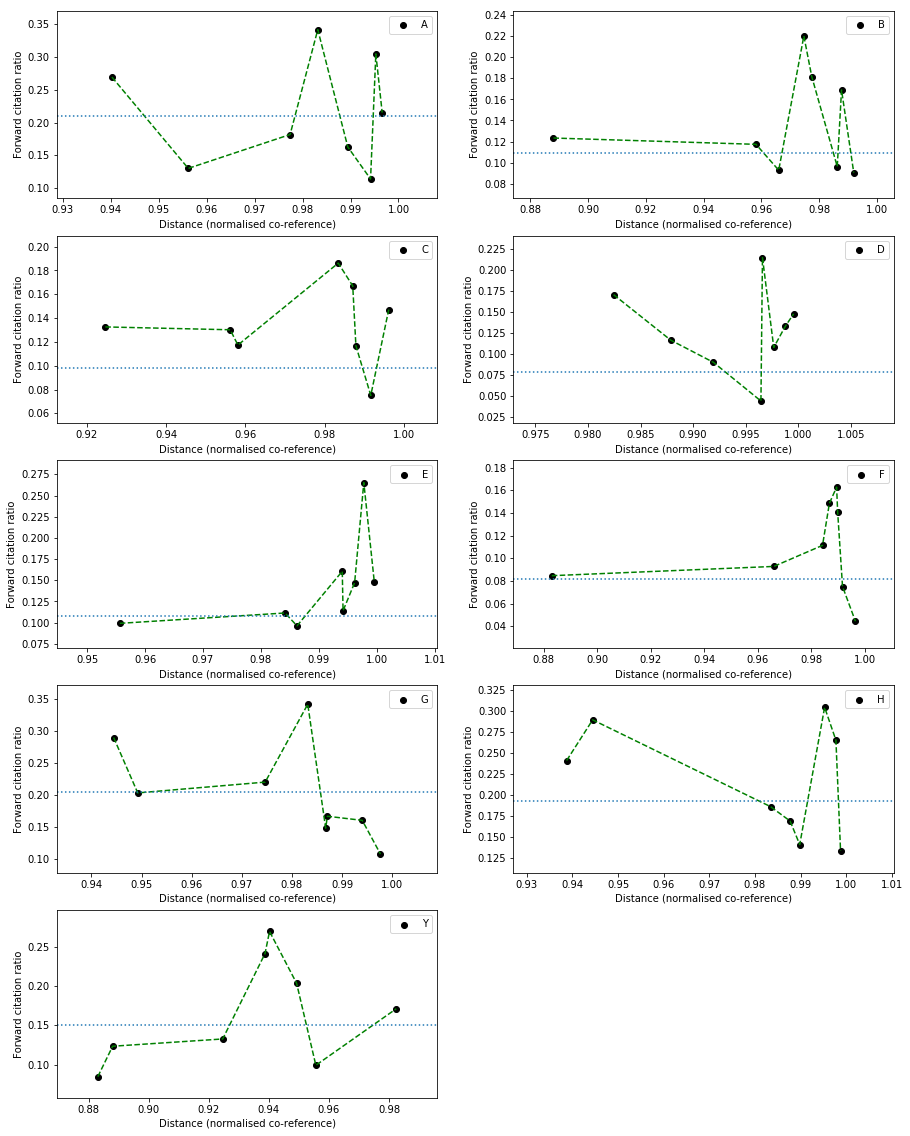

In [35]:
# create multiplot of the above
cpc_section_codes = ['A','B','C','D','E','F','G','H','Y']

fig = plt.figure(figsize=(15,20))

for plot_number in range(1,10):
    print('plot_number = ',plot_number)
    code = cpc_section_codes[plot_number-1]
    result = pd.concat([PVsection_patent_counts_norm[code], PVsection_forw_cite_ratios[code]], axis=1)
    result.columns = ['norm_patent_counts', 'forward_citation_ratio']
    result['distance'] = 1-result.norm_patent_counts
    # sort on norm_patent_counts
    result_sorted = result.sort_values(by='distance')
    result_to_plot = result_sorted[1:]
    self_citation_rate = result_sorted[:1].forward_citation_ratio.values[0]
    
    
    ax = fig.add_subplot(5,2,plot_number)
    ax.scatter(result_to_plot['distance'],result_to_plot['forward_citation_ratio'],c='black', label=code)
    ax.plot(result_to_plot['distance'],result_to_plot['forward_citation_ratio'],'g--',label='')
    ax.set_xlabel('Distance (normalised co-reference)')
    ax.set_ylabel('Forward citation ratio')
    ax.legend(loc='upper right')
    plt.axhline(y=self_citation_rate,ls='dotted')


plt.savefig("/Users/ahuxor/MSc/Thesis_Project/msc_thesis/Figs/cpc_sections_plot_distance_forward_cites.pdf", bbox_inches = 'tight')
plt.show()



## Do similar but for CPC3 codes in only one section


In [36]:
# get G section subset of data
pv_76_90_G_df = pv_76_90_df[pv_76_90_df.section_id =='G']
print(pv_76_90_G_df.head())
print('length of pv_76_90_G_df = ',len(pv_76_90_G_df))

     patent_id  GYEAR section_id subsection_id group_id
35     4350293   1982          G           G05     G05D
46     4689293   1987          G           G01     G01N
93     4695953   1987          G           G06     G06F
94     4695953   1987          G           G09     G09B
162    4413630   1983          G           G01     G01S
length of pv_76_90_G_df =  497956


In [37]:
# create list for unique_icl_section. Should just be the A to H sections
unique_cpc3_list_G = pv_76_90_G_df.subsection_id.unique().tolist()
unique_cpc3_list_G

['G05',
 'G01',
 'G06',
 'G09',
 'G02',
 'G07',
 'G10',
 'G04',
 'G21',
 'G08',
 'G03',
 'G11',
 'G16',
 'G12']

In [38]:
# create list of unique assignee numbers
unique_patents_G = pv_76_90_G_df.patent_id.unique()
len(unique_patents_G)

212271

In [39]:
# create starter df for feature vectors based on section
feature_vectors_df_G = pd.DataFrame({'cpc3' : unique_cpc3_list_G})
feature_vectors_df_G.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
cpc3,G05,G01,G06,G09,G02,G07,G10,G04,G21,G08,G03,G11,G16,G12


In [40]:
# TRY TO ONLY USE LISTS, TO THE VERY END
# now try and get vectors for each assignee of the number of patents they hold in each section

# num = number of patents to look at (to test code with small samples first)
def get_PV_CPC3_counts_for_patents_G(num):
    feature_vectors_list_of_lists_G =[]
    # first get list of (unique) assignees (try first five first to test code)
    range_of_patents = unique_patents_G[0:num]
    # then for each one of them, 
    for a_patent in range_of_patents:
        #print('patent number = ',a_patent)
        # look at all the patent subsections each patent has #
        temp = pv_76_90_G_df[pv_76_90_G_df.patent_id==a_patent].subsection_id
        subsection_codes_in_current_list = list(temp.values)
        #print(subsection_codes_in_current_list)
        #  and count instances of these if multiple instances of any 
        n = len(unique_cpc3_list_G)
        cpc3_codes_per_patent_list = []
        for m in range(0,n):
            current_cpc_subsection = unique_cpc3_list_G[m]
            counted = subsection_codes_in_current_list.count(current_cpc_subsection)
            cpc3_codes_per_patent_list.append(counted)
        feature_vectors_list_of_lists_G.append((cpc3_codes_per_patent_list))
    return(feature_vectors_list_of_lists_G)

In [41]:
# 212185 (full sample) takes 5.5 mins
j=212185
# %lprun -f get_patent_section_counts_for_patents feature_lists = get_patent_section_counts_for_patents(j)
PV_CPC3_counts_for_patents_G = get_PV_CPC3_counts_for_patents_G(j)

In [42]:
PV_CPC3_counts_for_patents_G_df = pd.DataFrame(PV_CPC3_counts_for_patents_G)

In [43]:
# add column names to df from unique_cpc_section_list names
PV_CPC3_counts_for_patents_G_df.columns = unique_cpc3_list_G

In [44]:
# add patent numbers as index 
# first get required number (function of j, remember), then convert to integer
patents_for_index = unique_patents_G[:len(PV_CPC3_counts_for_patents_G_df)]
patents_for_index
# then change index for df
indexed_PV_CPC3_counts_for_patents_G_df = PV_CPC3_counts_for_patents_G_df.set_index(patents_for_index)
indexed_PV_CPC3_counts_for_patents_G_df.tail()

,G05,G01,G06,G09,G02,G07,G10,G04,G21,G08,G03,G11,G16,G12
4463431,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3961200,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4074341,0,0,0,0,0,0,0,0,0,2,0,0,0,0
4836790,0,0,3,0,0,0,0,0,0,0,0,0,0,0
4215281,0,0,0,0,0,0,0,0,0,3,0,0,0,0


In [45]:
# create clipped version of df with value =1 for any value of 1 and above 
indexed_PV_CPC3_counts_for_patents_G_df_clipped = indexed_PV_CPC3_counts_for_patents_G_df.clip(0,1)
indexed_PV_CPC3_counts_for_patents_G_df_clipped.tail()

,G05,G01,G06,G09,G02,G07,G10,G04,G21,G08,G03,G11,G16,G12
4463431,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3961200,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4074341,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4836790,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4215281,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [46]:
len(indexed_PV_CPC3_counts_for_patents_G_df_clipped)

212185

In [47]:
j

212185

In [48]:

# 212185 (full sample) takes 19 mins

list_of_CPC3 = unique_cpc3_list_G
#create empty lists to hold values generated
firsts_list_CPC3_G = []
seconds_list_CPC3_G = []
ratio_list_CPC3_G = []
patent_counts_list_CPC3_G = []
# set threshold value for forward citations, to derive ratio of high to low forward citations
threshold = 20
# create short-name version of the long but descriptive df, for use in loop
short_name_df = indexed_PV_CPC3_counts_for_patents_G_df_clipped
for y in range(0,13):
    first = list_of_CPC3[y]
    for z in range(0,13):
        second = list_of_CPC3[z]
        #print('dyad=',first,'/', second)
        #get patents which have both of these sections
        matches_dyad = short_name_df[(short_name_df[first]==1) & (short_name_df[second]==1)]
        # throw out those that also have other sections (for clean sampling)
        matches_dyad_no_others = matches_dyad[matches_dyad.sum(axis=1)<3]
        #get actual patent numbers (used as index for thes dfs)
        patents = matches_dyad_no_others.index.values
        #print(patents)
        count_patents = len(patents)
        # obtain the number of forward citations
        forward_cites_list = []
        for a_patent in patents:
            # get record for this patent from 76-06-assg
            record = pat76_06_assg_df[pat76_06_assg_df.patent==a_patent]
            # have a case where the patent number has no record in pat76_06_assg_df, so exclude such cases
            if not record.empty:
                forward_cites = record.allcites.values[0] # get number of forward cites for each patent
                #print(forward_cites)
                forward_cites_list.append(forward_cites)
        # derive ratio citations above/below threshold
        num_above_threshold = len([i for i in forward_cites_list if i >= threshold])
        num_below_threshold = len([i for i in forward_cites_list if i < threshold])
        # need to handle num_below_threshold =0, as get divide by zero error in some cases
        if (num_below_threshold == 0):
            num_below_threshold = 1.0
        citations_ratio = num_above_threshold/num_below_threshold
        #print('ratio = ', citations_ratio)
        firsts_list_CPC3_G.append(first)
        seconds_list_CPC3_G.append(second)
        ratio_list_CPC3_G.append(citations_ratio)
        patent_counts_list_CPC3_G.append(count_patents)
print('DONE')       

DONE


In [49]:
# create dataframe from these lists for the forward citations
forw_cite_ratio_df_CPC3_G = pd.DataFrame(
    {'first_section': firsts_list_CPC3_G,
     'second_section': seconds_list_CPC3_G,
     'forw_cite_ratio': ratio_list_CPC3_G
    })

# create dataframe from these lists for patent counts
patent_counts_df_CPC3_G = pd.DataFrame(
    {'first_section': firsts_list_CPC3_G,
     'second_section': seconds_list_CPC3_G,
     'patent_counts': patent_counts_list_CPC3_G
    })

In [50]:
# convert the forward citation dataframe into another representing the matrix
CPC3_G_forw_cite_ratio_df = forw_cite_ratio_df_CPC3_G.pivot(index='first_section',columns='second_section',values='forw_cite_ratio')

In [51]:
# normalize the counts to account for different patent proposensity
normalized_counts_list_CPC3_G = []
for n in range(0,len(patent_counts_df_CPC3_G)):
    record = patent_counts_df_CPC3_G[n:n+1]
    first = record.first_section.values[0]
    first_lone = patent_counts_df_CPC3_G[(patent_counts_df_CPC3_G.first_section==first) & (patent_counts_df_CPC3_G.second_section==first) ]
    first_lone_counts = first_lone.patent_counts.values[0]
    first_lone_counts

    second = record.second_section.values[0]
    second_lone = patent_counts_df_CPC3_G[(patent_counts_df_CPC3_G.first_section==second) & (patent_counts_df_CPC3_G.second_section==second) ]
    second_lone_counts = second_lone.patent_counts.values[0]
    second_lone_counts
    if first==second:
        sum_lone_values = first_lone_counts
    else:
        sum_lone_values = first_lone_counts+second_lone_counts
    normalized_counts = record.patent_counts.values[0]/sum_lone_values
    normalized_counts_list_CPC3_G.append(normalized_counts)





In [52]:
# add the normalised counts to the df
patent_counts_df_CPC3_G['normalized_counts'] = normalized_counts_list_CPC3_G
patent_counts_df_CPC3_G.tail()

,first_section,patent_counts,second_section,normalized_counts
164,G16,0,G21,0.000000
165,G16,1,G08,0.000189
166,G16,0,G03,0.000000
167,G16,1,G11,0.000042
168,G16,157,G16,1.000000


In [53]:
# convert the forward citation dataframe into another representing the matrix
CPC3_G_patent_counts = patent_counts_df_CPC3_G.pivot(index='first_section',columns='second_section',values='patent_counts')
# as above for for normalized counts
CPC3_G_patent_counts_norm = patent_counts_df_CPC3_G.pivot(index='first_section',columns='second_section',values='normalized_counts')

In [54]:
CPC3_G_patent_counts

second_section,G01,G02,G03,G04,G05,G06,G07,G08,G09,G10,G11,G16,G21
first_section,,,,,,,,,,,,,
G01,74951,1195,524,151,925,1290,298,748,232,650,438,13,433
G02,1195,19990,1026,74,26,273,5,32,520,16,293,0,32
G03,524,1026,33944,8,90,347,33,17,80,4,385,0,78
G04,151,74,8,3756,79,84,71,21,76,49,24,0,0
G05,925,26,90,79,13104,402,37,58,33,5,142,5,24
G06,1290,273,347,84,402,22728,1496,79,723,111,1073,70,8
G07,298,5,33,71,37,1496,6162,142,51,14,46,0,1
G08,748,32,17,21,58,79,142,5132,82,54,17,1,2
G09,232,520,80,76,33,723,51,82,9611,84,138,4,6


/Users/ahuxor/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


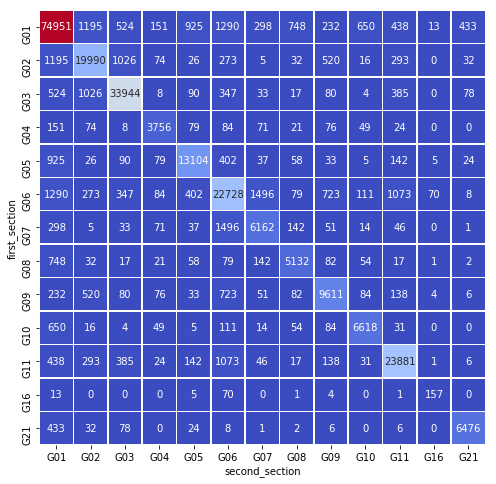

In [55]:
# plot raw counts
# first change O values to miniscule obne, to allow log to work

fig = plt.figure(figsize=(8,8))
sns.heatmap(CPC3_G_patent_counts, cmap='coolwarm', linewidths=0.5, cbar=False,fmt='d', annot=True)
plt.savefig("/Users/ahuxor/MSc/Thesis_Project/msc_thesis/Figs/CPC3_G_patent_counts_heatmap.pdf", bbox_inches = 'tight')
fig.show()

/Users/ahuxor/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


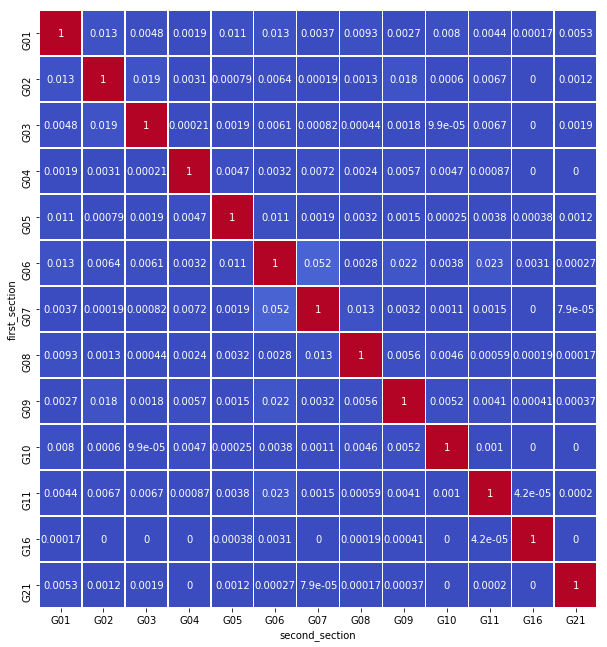

In [56]:
# plot normalised counts
fig = plt.figure(figsize=(10,11))
sns.heatmap(CPC3_G_patent_counts_norm, cmap='coolwarm', linewidths=0.5, cbar=False, annot=True)
plt.savefig("/Users/ahuxor/MSc/Thesis_Project/msc_thesis/Figs/CPC3_G_patent_counts_norm_heatmap.pdf", bbox_inches = 'tight')
fig.show()

/Users/ahuxor/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


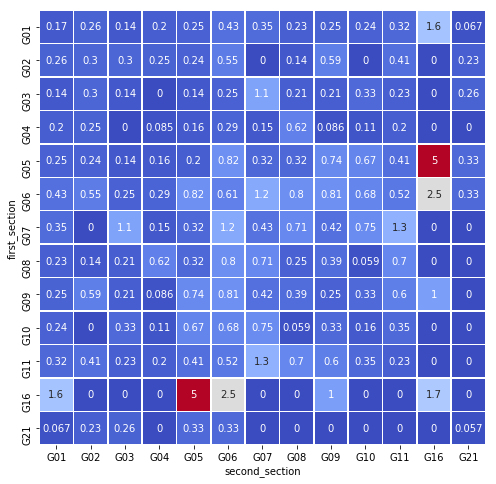

In [57]:
# plot forward citation ratios above/below threshold of 20
fig = plt.figure(figsize=(8,8))
sns.heatmap(CPC3_G_forw_cite_ratio_df, cmap='coolwarm', linewidths=0.5, cbar=False, annot=True)
plt.savefig("/Users/ahuxor/MSc/Thesis_Project/msc_thesis/Figs/CPC3_G_cite_ratios_heatmap.pdf", bbox_inches = 'tight')
fig.show()

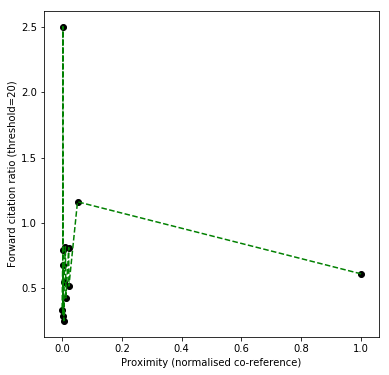

In [58]:
# plot forward cites against normal co-reference, for G06 (computing)
#print(CPC3_G_patent_counts_norm.G06)
#print(CPC3_G_forw_cite_ratio_df.G06)
# create df from these series
result = pd.concat([CPC3_G_patent_counts_norm.G06, CPC3_G_forw_cite_ratio_df.G06], axis=1)
#rename columns
result.columns = ['norm_patent_counts', 'forward_citation_ratio']
# sort on norm_patent_counts
result_sorted = result.sort_values(by='norm_patent_counts', ascending = False)

fig = plt.figure(figsize=(6,6))
plt.scatter(result_sorted['norm_patent_counts'],result_sorted['forward_citation_ratio'],c='black')
plt.plot(result_sorted['norm_patent_counts'],result_sorted['forward_citation_ratio'],'g--')
plt.xlabel('Proximity (normalised co-reference)')
plt.ylabel('Forward citation ratio (threshold=20)')
plt.show()

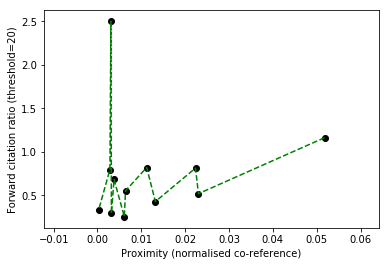

In [59]:
# plot forward cites against normal co-reference, for G06 (computing)
# but remove G06 iteslf as biases plot
#print(CPC3_G_patent_counts_norm.G06)
#print(CPC3_G_forw_cite_ratio_df.G06)
# create df from these series
result = pd.concat([CPC3_G_patent_counts_norm.G06, CPC3_G_forw_cite_ratio_df.G06], axis=1)
#rename columns
result.columns = ['norm_patent_counts', 'forward_citation_ratio']
# sort on norm_patent_counts
result_sorted = result.sort_values(by='norm_patent_counts', ascending = False)
result_to_plot = result_sorted[1:]
#fig = plt.figure(figsize=(6,6))
plt.scatter(result_to_plot['norm_patent_counts'],result_to_plot['forward_citation_ratio'],c='black')
plt.plot(result_to_plot['norm_patent_counts'],result_to_plot['forward_citation_ratio'],'g--')
plt.xlabel('Proximity (normalised co-reference)')
plt.ylabel('Forward citation ratio (threshold=20)')
plt.show()
plt.savefig("/Users/ahuxor/MSc/Thesis_Project/msc_thesis/Figs/G06_plot_proximity_forward_cites2.pdf", bbox_inches = 'tight')



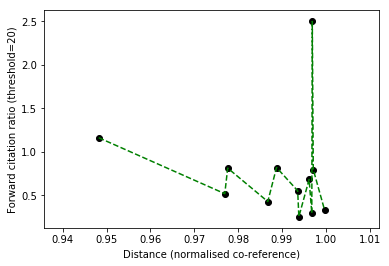

In [60]:
# plot forward cites against normal co-reference, for G06 (computing)
# BUT CONVERTING PROXIMITY TO DISTANCE
# but remove G06 iteslf as biases plot
#print(CPC3_G_patent_counts_norm.G06)
#print(CPC3_G_forw_cite_ratio_df.G06)
# create df from these series
result = pd.concat([CPC3_G_patent_counts_norm.G06, CPC3_G_forw_cite_ratio_df.G06], axis=1)
#rename columns
result.columns = ['norm_patent_counts', 'forward_citation_ratio']
result['distance'] = 1-result.norm_patent_counts
# sort on norm_patent_counts
result_sorted = result.sort_values(by='distance')
result_to_plot = result_sorted[1:]
#fig = plt.figure(figsize=(6,6))
plt.scatter(result_to_plot['distance'],result_to_plot['forward_citation_ratio'],c='black')
plt.plot(result_to_plot['distance'],result_to_plot['forward_citation_ratio'],'g--')
plt.xlabel('Distance (normalised co-reference)')
plt.ylabel('Forward citation ratio (threshold=20)')
plt.show()
plt.savefig("/Users/ahuxor/MSc/Thesis_Project/msc_thesis/Figs/G06_plot_distance_forward_cites.pdf", bbox_inches = 'tight')



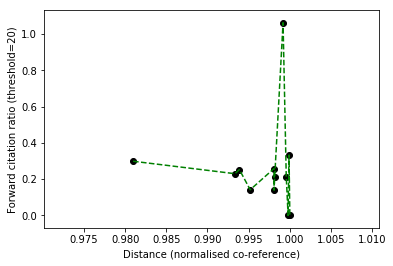

In [61]:
# plot forward cites against normal co-reference, for G03 (PHOTOGRAPHY; CINEMATOGRAPHY; ANALOGOUS TECHNIQUES USING WAVES OTHER THAN OPTICAL WAVES; ELECTROGRAPHY; HOLOGRAPHY)
# BUT CONVERTING PROXIMITY TO DISTANCE
# but remove G03 iteslf as biases plot
#print(CPC3_G_patent_counts_norm.G06)
#print(CPC3_G_forw_cite_ratio_df.G06)
# create df from these series
result = pd.concat([CPC3_G_patent_counts_norm.G03, CPC3_G_forw_cite_ratio_df.G03], axis=1)
#rename columns
result.columns = ['norm_patent_counts', 'forward_citation_ratio']
result['distance'] = 1-result.norm_patent_counts
# sort on norm_patent_counts
result_sorted = result.sort_values(by='distance')
result_to_plot = result_sorted[1:]
#fig = plt.figure(figsize=(6,6))
plt.scatter(result_to_plot['distance'],result_to_plot['forward_citation_ratio'],c='black')
plt.plot(result_to_plot['distance'],result_to_plot['forward_citation_ratio'],'g--')
plt.xlabel('Distance (normalised co-reference)')
plt.ylabel('Forward citation ratio (threshold=20)')
plt.show()
plt.savefig("/Users/ahuxor/MSc/Thesis_Project/msc_thesis/Figs/G03_plot_distance_forward_cites.pdf", bbox_inches = 'tight')



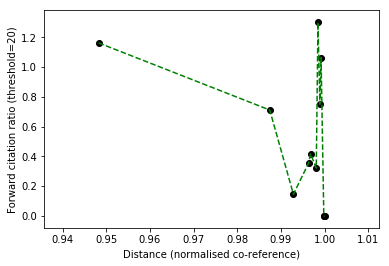

In [62]:
# plot forward cites against normal co-reference, for G07 
# but remove G07 iteslf as biases plot

# create df from these series
result = pd.concat([CPC3_G_patent_counts_norm.G07, CPC3_G_forw_cite_ratio_df.G07], axis=1)
#rename columns
result.columns = ['norm_patent_counts', 'forward_citation_ratio']
result['distance'] = 1-result.norm_patent_counts
# sort on norm_patent_counts
result_sorted = result.sort_values(by='distance')
result_to_plot = result_sorted[1:]
#fig = plt.figure(figsize=(6,6))
plt.scatter(result_to_plot['distance'],result_to_plot['forward_citation_ratio'],c='black')
plt.plot(result_to_plot['distance'],result_to_plot['forward_citation_ratio'],'g--')
plt.xlabel('Distance (normalised co-reference)')
plt.ylabel('Forward citation ratio (threshold=20)')
plt.show()



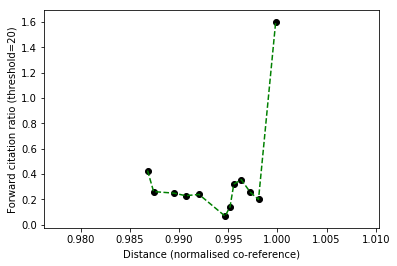

In [63]:
# plot forward cites against normal co-reference, for G01
# but remove G01 iteslf as biases plot

# create df from these series
result = pd.concat([CPC3_G_patent_counts_norm.G01, CPC3_G_forw_cite_ratio_df.G01], axis=1)
#rename columns
result.columns = ['norm_patent_counts', 'forward_citation_ratio']
result['distance'] = 1-result.norm_patent_counts
# sort on norm_patent_counts
result_sorted = result.sort_values(by='distance')
result_to_plot = result_sorted[1:]
#fig = plt.figure(figsize=(6,6))
plt.scatter(result_to_plot['distance'],result_to_plot['forward_citation_ratio'],c='black')
plt.plot(result_to_plot['distance'],result_to_plot['forward_citation_ratio'],'g--')
plt.xlabel('Distance (normalised co-reference)')
plt.ylabel('Forward citation ratio (threshold=20)')
plt.show()



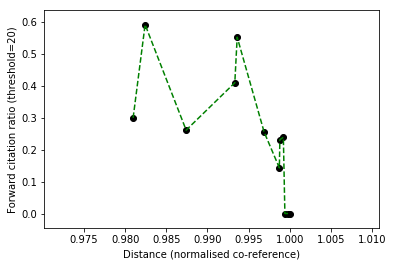

In [64]:
# plot forward cites against normal co-reference, for G02
# but remove G02 iteslf as biases plot

# create df from these series
result = pd.concat([CPC3_G_patent_counts_norm.G02, CPC3_G_forw_cite_ratio_df.G02], axis=1)
#rename columns
result.columns = ['norm_patent_counts', 'forward_citation_ratio']
result['distance'] = 1-result.norm_patent_counts
# sort on norm_patent_counts
result_sorted = result.sort_values(by='distance')
result_to_plot = result_sorted[1:]
#fig = plt.figure(figsize=(6,6))
plt.scatter(result_to_plot['distance'],result_to_plot['forward_citation_ratio'],c='black')
plt.plot(result_to_plot['distance'],result_to_plot['forward_citation_ratio'],'g--')
plt.xlabel('Distance (normalised co-reference)')
plt.ylabel('Forward citation ratio (threshold=20)')
plt.show()



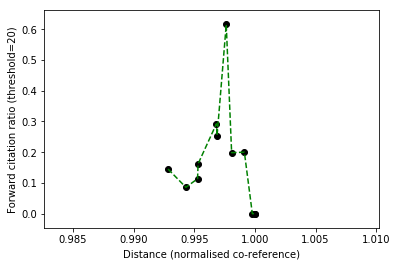

In [65]:
# plot forward cites against normal co-reference, for G04
# but remove G04 iteslf as biases plot

# create df from these series
result = pd.concat([CPC3_G_patent_counts_norm.G04, CPC3_G_forw_cite_ratio_df.G04], axis=1)
#rename columns
result.columns = ['norm_patent_counts', 'forward_citation_ratio']
result['distance'] = 1-result.norm_patent_counts
# sort on norm_patent_counts
result_sorted = result.sort_values(by='distance')
result_to_plot = result_sorted[1:]
#fig = plt.figure(figsize=(6,6))
plt.scatter(result_to_plot['distance'],result_to_plot['forward_citation_ratio'],c='black')
plt.plot(result_to_plot['distance'],result_to_plot['forward_citation_ratio'],'g--')
plt.xlabel('Distance (normalised co-reference)')
plt.ylabel('Forward citation ratio (threshold=20)')
plt.show()



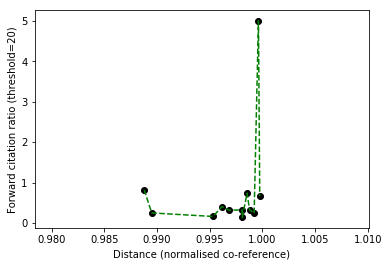

In [66]:
# plot forward cites against normal co-reference, for G05
# but remove G05 iteslf as biases plot

# create df from these series
result = pd.concat([CPC3_G_patent_counts_norm.G05, CPC3_G_forw_cite_ratio_df.G05], axis=1)
#rename columns
result.columns = ['norm_patent_counts', 'forward_citation_ratio']
result['distance'] = 1-result.norm_patent_counts
# sort on norm_patent_counts
result_sorted = result.sort_values(by='distance')
result_to_plot = result_sorted[1:]
#fig = plt.figure(figsize=(6,6))
plt.scatter(result_to_plot['distance'],result_to_plot['forward_citation_ratio'],c='black')
plt.plot(result_to_plot['distance'],result_to_plot['forward_citation_ratio'],'g--')
plt.xlabel('Distance (normalised co-reference)')
plt.ylabel('Forward citation ratio (threshold=20)')
plt.show()



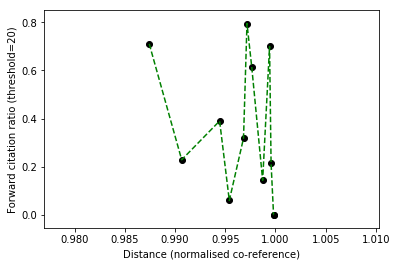

In [67]:
# plot forward cites against normal co-reference, for G08
# but remove this focal CPC3 iteslf as biases plot

# create df from these series
result = pd.concat([CPC3_G_patent_counts_norm.G08, CPC3_G_forw_cite_ratio_df.G08], axis=1)
#rename columns
result.columns = ['norm_patent_counts', 'forward_citation_ratio']
result['distance'] = 1-result.norm_patent_counts
# sort on norm_patent_counts
result_sorted = result.sort_values(by='distance')
result_to_plot = result_sorted[1:]
#fig = plt.figure(figsize=(6,6))
plt.scatter(result_to_plot['distance'],result_to_plot['forward_citation_ratio'],c='black')
plt.plot(result_to_plot['distance'],result_to_plot['forward_citation_ratio'],'g--')
plt.xlabel('Distance (normalised co-reference)')
plt.ylabel('Forward citation ratio (threshold=20)')
plt.show()



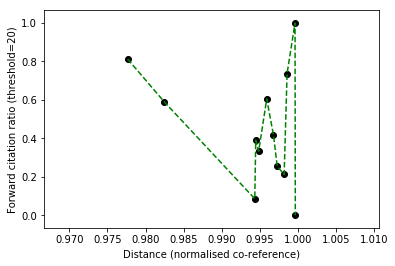

In [68]:
# plot forward cites against normal co-reference, for G09
# but remove this focal CPC3 iteslf as biases plot

# create df from these series
result = pd.concat([CPC3_G_patent_counts_norm.G09, CPC3_G_forw_cite_ratio_df.G09], axis=1)
#rename columns
result.columns = ['norm_patent_counts', 'forward_citation_ratio']
result['distance'] = 1-result.norm_patent_counts
# sort on norm_patent_counts
result_sorted = result.sort_values(by='distance')
result_to_plot = result_sorted[1:]
#fig = plt.figure(figsize=(6,6))
plt.scatter(result_to_plot['distance'],result_to_plot['forward_citation_ratio'],c='black')
plt.plot(result_to_plot['distance'],result_to_plot['forward_citation_ratio'],'g--')
plt.xlabel('Distance (normalised co-reference)')
plt.ylabel('Forward citation ratio (threshold=20)')
plt.show()



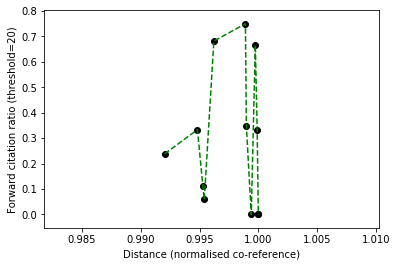

In [69]:
# plot forward cites against normal co-reference, for G10
# but remove this focal CPC3 iteslf as biases plot

# create df from these series
result = pd.concat([CPC3_G_patent_counts_norm.G10, CPC3_G_forw_cite_ratio_df.G10], axis=1)
#rename columns
result.columns = ['norm_patent_counts', 'forward_citation_ratio']
result['distance'] = 1-result.norm_patent_counts
# sort on norm_patent_counts
result_sorted = result.sort_values(by='distance')
result_to_plot = result_sorted[1:]
#fig = plt.figure(figsize=(6,6))
plt.scatter(result_to_plot['distance'],result_to_plot['forward_citation_ratio'],c='black')
plt.plot(result_to_plot['distance'],result_to_plot['forward_citation_ratio'],'g--')
plt.xlabel('Distance (normalised co-reference)')
plt.ylabel('Forward citation ratio (threshold=20)')
plt.show()



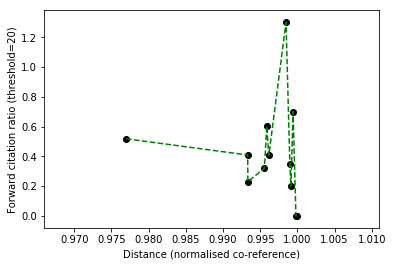

In [70]:
# plot forward cites against normal co-reference, for G11
# but remove this focal CPC3 iteslf as biases plot

# create df from these series
result = pd.concat([CPC3_G_patent_counts_norm.G11, CPC3_G_forw_cite_ratio_df.G11], axis=1)
#rename columns
result.columns = ['norm_patent_counts', 'forward_citation_ratio']
result['distance'] = 1-result.norm_patent_counts
# sort on norm_patent_counts
result_sorted = result.sort_values(by='distance')
result_to_plot = result_sorted[1:]
#fig = plt.figure(figsize=(6,6))
plt.scatter(result_to_plot['distance'],result_to_plot['forward_citation_ratio'],c='black')
plt.plot(result_to_plot['distance'],result_to_plot['forward_citation_ratio'],'g--')
plt.xlabel('Distance (normalised co-reference)')
plt.ylabel('Forward citation ratio (threshold=20)')
plt.show()



xx =  0.05696099232903542


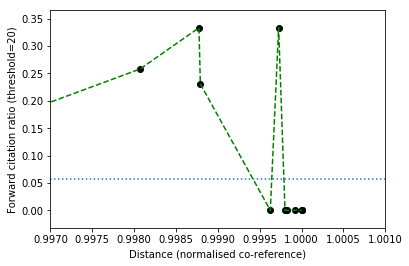

In [72]:
# plot forward cites against normal co-reference, for G21
# but remove this focal CPC3 iteslf as biases plot

# create df from these series
result = pd.concat([CPC3_G_patent_counts_norm.G21, CPC3_G_forw_cite_ratio_df.G21], axis=1)
#rename columns
result.columns = ['norm_patent_counts', 'forward_citation_ratio']
result['distance'] = 1-result.norm_patent_counts
# sort on norm_patent_counts
result_sorted = result.sort_values(by='distance')
result_to_plot = result_sorted[1:]
xx = result_sorted[:1].forward_citation_ratio.values[0]
print('xx = ',xx)
#fig = plt.figure(figsize=(6,6))
plt.scatter(result_to_plot['distance'],result_to_plot['forward_citation_ratio'],c='black')
plt.plot(result_to_plot['distance'],result_to_plot['forward_citation_ratio'],'g--')
plt.xlabel('Distance (normalised co-reference)')
plt.ylabel('Forward citation ratio (threshold=20)')
plt.xlim([0.997,1.001])
plt.axhline(y=xx,ls='dotted')
plt.show()



plot_number =  1
plot_number =  2
plot_number =  3
plot_number =  4
plot_number =  5
plot_number =  6
plot_number =  7
plot_number =  8
plot_number =  9
plot_number =  10
plot_number =  11
plot_number =  12


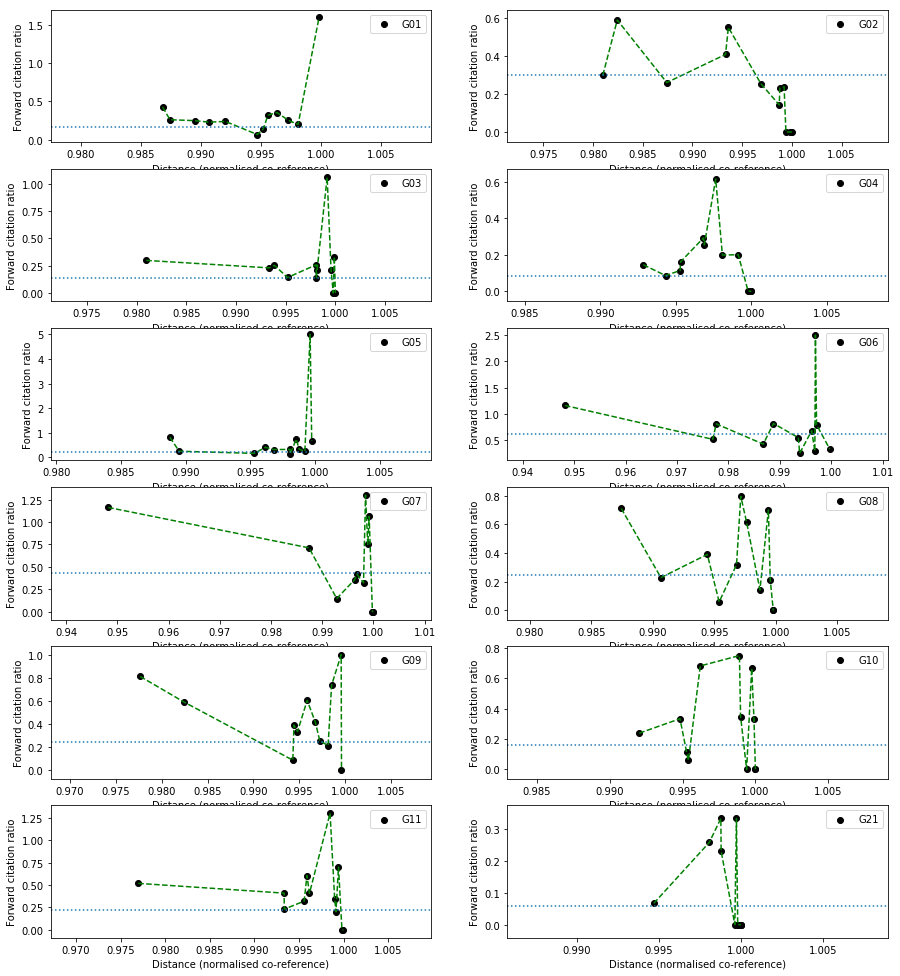

In [76]:
# create multiplot of the above
ipc3_g_codes = ['G01','G02','G03','G04','G05','G06','G07','G08','G09','G10','G11','G21']

fig = plt.figure(figsize=(15,20))

for plot_number in range(1,13):
    print('plot_number = ',plot_number)
    code = ipc3_g_codes[plot_number-1]
    result = pd.concat([CPC3_G_patent_counts_norm[code], CPC3_G_forw_cite_ratio_df[code]], axis=1)
    result.columns = ['norm_patent_counts', 'forward_citation_ratio']
    result['distance'] = 1-result.norm_patent_counts
    # sort on norm_patent_counts
    result_sorted = result.sort_values(by='distance')
    result_to_plot = result_sorted[1:]
    self_citation_rate = result_sorted[:1].forward_citation_ratio.values[0]
    
    
    ax = fig.add_subplot(7,2,plot_number)
    ax.scatter(result_to_plot['distance'],result_to_plot['forward_citation_ratio'],c='black', label=code)
    ax.plot(result_to_plot['distance'],result_to_plot['forward_citation_ratio'],'g--',label='')
    ax.set_xlabel('Distance (normalised co-reference)')
    ax.set_ylabel('Forward citation ratio')
    ax.legend(loc='upper right')
    plt.axhline(y=self_citation_rate,ls='dotted')


plt.savefig("/Users/ahuxor/MSc/Thesis_Project/msc_thesis/Figs/G_section_plot_distance_forward_cites.pdf", bbox_inches = 'tight')
plt.show()


In [77]:
result_sorted

,norm_patent_counts,forward_citation_ratio,distance
first_section,,,
G21,1.000000,0.056961,0.000000
G01,0.005318,0.066502,0.994682
G03,0.001930,0.258065,0.998070
G05,0.001226,0.333333,0.998774
G02,0.001209,0.230769,0.998791
G09,0.000373,0.000000,0.999627
G06,0.000274,0.333333,0.999726
G11,0.000198,0.000000,0.999802
G08,0.000172,0.000000,0.999828


In [78]:
# Most 'value' for G06 comes from link with G07
# get some example patents to illustrate
g06_patents = pv_76_90_df[pv_76_90_df.subsection_id=='G06'].patent_id.unique().tolist()
print(len(g06_patents))

23463


In [79]:

# full sample not ended after 3 hours, so using 5000 as only need a fair subset (33 min)

!date
g06_patents = pv_76_90_df[pv_76_90_df.subsection_id=='G06'].patent_id.values

g06_g07_patents = []
for a_patent in g06_patents[:5000]:
    temp = pv_76_90_df[(pv_76_90_df.patent_id==a_patent) & (pv_76_90_df.subsection_id=='G07')]
    joint_patent = list(set(temp.patent_id.values))
    # print(joint_patent)
    if joint_patent:
        g06_g07_patents.append(joint_patent)
#print('g06_g07_patents = ', g06_g07_patents)

Thu  4 Jul 2019 07:08:29 BST


In [80]:
g06_g07_patents_df = pd.DataFrame(g06_g07_patents)
g06_g07_patents_df.columns=['patent']

In [81]:
g06_g07_patents_df.head()


,patent
0,4814589
1,4814589
2,4814589
3,4814589
4,4814589


In [82]:
# merge with file X to get forward cites
g06_g07_patents_allcites_df = pd.merge(g06_g07_patents_df,pat76_06_assg_df,how='left',on='patent')

In [83]:
g06_g07_patents_allcites_df.sort_values(by='allcites', ascending = False).head(40)

,patent,allcites,appyear,asscode,assgnum,cat,cat_ocl,cclass,country,ddate,...,state,status,subcat,subcat_ocl,subclass,subclass1,subclass1_ocl,subclass_ocl,term_extension,uspto_assignee
383,4799156,471,1986,2.0,1.0,2.0,2.0,705/26,US,NaT,...,NY,,25.0,22.0,26.0,26,401,401.0,0,547560.0
374,4799156,471,1986,2.0,1.0,2.0,2.0,705/26,US,NaT,...,NY,,25.0,22.0,26.0,26,401,401.0,0,547560.0
384,4799156,471,1986,2.0,1.0,2.0,2.0,705/26,US,NaT,...,NY,,25.0,22.0,26.0,26,401,401.0,0,547560.0
385,4799156,471,1986,2.0,1.0,2.0,2.0,705/26,US,NaT,...,NY,,25.0,22.0,26.0,26,401,401.0,0,547560.0
381,4799156,471,1986,2.0,1.0,2.0,2.0,705/26,US,NaT,...,NY,,25.0,22.0,26.0,26,401,401.0,0,547560.0
380,4799156,471,1986,2.0,1.0,2.0,2.0,705/26,US,NaT,...,NY,,25.0,22.0,26.0,26,401,401.0,0,547560.0
379,4799156,471,1986,2.0,1.0,2.0,2.0,705/26,US,NaT,...,NY,,25.0,22.0,26.0,26,401,401.0,0,547560.0
378,4799156,471,1986,2.0,1.0,2.0,2.0,705/26,US,NaT,...,NY,,25.0,22.0,26.0,26,401,401.0,0,547560.0
377,4799156,471,1986,2.0,1.0,2.0,2.0,705/26,US,NaT,...,NY,,25.0,22.0,26.0,26,401,401.0,0,547560.0
375,4799156,471,1986,2.0,1.0,2.0,2.0,705/26,US,NaT,...,NY,,25.0,22.0,26.0,26,401,401.0,0,547560.0


In [84]:
!jupyter nbconvert --to script heatmaps_PV_data.ipynb

[NbConvertApp] Converting notebook heatmaps_PV_data.ipynb to script
[NbConvertApp] Writing 35979 bytes to heatmaps_PV_data.py
